<a href="https://colab.research.google.com/github/yigagilbert/cassava_whitefly-detection/blob/main/whitefly_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy.random import seed
seed(1)
import os
import keras
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Conv3D,BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from time import strftime, localtime

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

**MODEL** **DEF**.

In [ ]:
# Instatiate model
model = Sequential()

In [ ]:
model.add(Conv2D(512, kernel_size=(5, 5), input_shape=(25, 25, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, kernel_size=(5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
# # model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.33))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 512)       38912     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 256)         3277056   
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 256)        0         
 2D)                                                             
                                                        

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.0001), loss = 'binary_crossentropy',metrics=['accuracy'])

In [ ]:
paths = "weights/"+strftime("%m-%d-%Y_%H:%M:%S")+"_weights.{epoch:02d}.h5"
paths

'weights/07-07-2022_09:54:06_weights.{epoch:02d}.h5'

In [ ]:
# paths = "weights_25/weights.{epoch:02d}.h5"
monitor_progress = ModelCheckpoint(paths,monitor="val_accuracy", verbose=1, save_best_only=True)

**DATA** **PRE**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/25by25.zip -d /content/sample_data

In [ ]:
base_dir ='/content/sample_data/25by25'  
traindir = os.path.join(base_dir,"train")
validationdir = os.path.join(base_dir,"val")
testdir = os.path.join(base_dir,"test") 
patch_size=25

In [ ]:
traindatagen = ImageDataGenerator( rotation_range=40,
        width_shift_range=0.4,
        height_shift_range=0.4,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=True,
        fill_mode='nearest')
validationdatagen = ImageDataGenerator(rescale=1/225.)
testdatagen = ImageDataGenerator(rescale=1/225.)

In [ ]:
traingen = traindatagen.flow_from_directory(
                               directory=traindir,
                                target_size=(patch_size,patch_size),
                                batch_size = 8,
                                class_mode='binary')
validationgen = validationdatagen.flow_from_directory(
                               directory=validationdir,
                                target_size=(patch_size,patch_size),
                                batch_size = 8,
                                class_mode='binary')
testgen = testdatagen.flow_from_directory(
                                directory=testdir,
                                target_size=(patch_size,patch_size),
                                batch_size = 8,                                
                                class_mode='binary')

Found 2781 images belonging to 2 classes.
Found 347 images belonging to 2 classes.
Found 349 images belonging to 2 classes.


In [ ]:
validationgen.class_indices

{'negative': 0, 'positive': 1}

In [ ]:
traingen.__len__()

348

In [ ]:
history = model.fit(
                    traingen,
                    epochs=300,
                    callbacks=[monitor_progress],
                    validation_data=validationgen)

Epoch 1/300
347/348 [============================>.] - ETA: 0s - loss: 0.4621 - accuracy: 0.8273
Epoch 1: val_accuracy improved from -inf to 0.90202, saving model to weights/07-07-2022_05:42:07_weights.01.h5
348/348 [==============================] - 5s 13ms/step - loss: 0.4613 - accuracy: 0.8278 - val_loss: 0.4505 - val_accuracy: 0.9020
Epoch 2/300
344/348 [============================>.] - ETA: 0s - loss: 0.3528 - accuracy: 0.8778
Epoch 2: val_accuracy improved from 0.90202 to 0.92219, saving model to weights/07-07-2022_05:42:07_weights.02.h5
348/348 [==============================] - 4s 12ms/step - loss: 0.3517 - accuracy: 0.8781 - val_loss: 0.2977 - val_accuracy: 0.9222
Epoch 3/300
346/348 [============================>.] - ETA: 0s - loss: 0.3381 - accuracy: 0.8759
Epoch 3: val_accuracy did not improve from 0.92219
348/348 [==============================] - 4s 13ms/step - loss: 0.3373 - accuracy: 0.8763 - val_loss: 0.3672 - val_accuracy: 0.9164
Epoch 4/300
346/348 [================

In [ ]:
model.evaluate_generator(testgen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.028958192095160484, 0.9885386824607849]

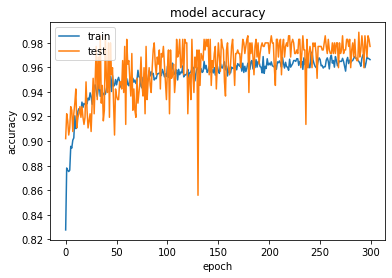

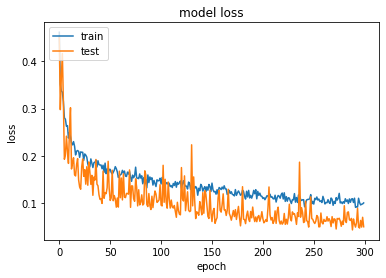

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("acc_31_05_19.png")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss_31_05_19.png")
plt.show()

**Eval**

In [ ]:
import cv2
import glob
import random
import numpy as np

In [ ]:
test_model = load_model("/content/gdrive/MyDrive/my_models/weights/07-07-2022_05:42:07_weights.35.h5")

In [ ]:
#!unzip /content/gdrive/MyDrive/25by25.zip -d /content/gdrive/MyDrive

Archive:  /content/gdrive/MyDrive/25by25.zip
replace /content/gdrive/MyDrive/25by25/test/negative/image1.neg196.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
root_img_path ="/content/gdrive/MyDrive/25by25/test"

In [ ]:
def load_images(img_path):
    return np.array([cv2.imread(img_path+file) for file in os.listdir(img_path)])

In [ ]:
def get_label(prediction,idx):
    if prediction[idx]<0.5:
        return "Negative"
    return "Positive"

In [ ]:
def get_neg_class(prediction_class, N):
    arr = []
    while len(arr)<N+1:
        idx = random.randint(0,len(prediction_class)-1)
        if prediction_class[idx]<0.5 and idx not in arr:
            arr.append(idx)
    return arr

In [ ]:
def get_pos_class(prediction_class, N):
    arr = []
    while len(arr)<N+1:
        idx = random.randint(0,len(prediction_class)-1)
        if prediction_class[idx]>=0.5 and idx not in arr:
            arr.append(idx)
    return arr

In [ ]:
# Create positive and negative batch for predictions
positive_class = load_images(os.path.join(root_img_path,"positive/"))
negative_class = load_images(os.path.join(root_img_path,"negative/"))

In [ ]:
# Predictions for positive class
#predicted_pos = model.predict_classes(positive_class)
#predicted_pos = model.predict_on_batch(positive_class)
predicted_pos = (test_model.predict(positive_class) >= 0.5).astype("int32")
len(predicted_pos)
#print(predicted_pos)

138

In [ ]:
# Predictions for negative class
#predicted_neg = model.predict_on_batch(negative_class)
#predicted_neg = model.predict_classes(negative_class)
predicted_neg = (test_model.predict(negative_class) < 0.5).astype("int32")
len(predicted_neg)
#print(predicted_neg)

211

In [ ]:
# Get TP(True Positives) and FN(False Negatives)
TP = [p for p in predicted_pos if p >=0.5]
FN = [p for p in predicted_pos if p<0.5]
print("Positive examples classified positive (TP): ",len(TP))
print("Positive examples classified negative (FN): ",len(FN))

Positive examples classified positive (TP):  128
Positive examples classified negative (FN):  10


In [ ]:
# Get TN(True Negatives) and FP(False Positives)
FP = [p for p in predicted_neg if p >=0.5]
TN = [p for p in predicted_neg if p<0.5]
print("Negative examples classified positive (FP): ",len(FP))
print("Negative examples classified negative (TN): ",len(TN))

Negative examples classified positive (FP):  102
Negative examples classified negative (TN):  109


In [ ]:
def get_confusion_matrix(tp, fp, tn, fn):
    pr = tp/(tp+fp)
    rc = tp/(tp+fn)
    f1_score = 2*((pr*rc)/(pr+rc))
    print("TP \t FP \t TN \t FN\n")
    print(str(tp)+"\t"+str(fp)+"\t"+str(tn)+"\t"+str(fn))
    return pr, rc, f1_score

In [ ]:
# Confusion matrix
Precision, Recall, F1_Score = get_confusion_matrix(len(TP),len(FP),len(TN),len(FN))
print("\n")
print("Precision:\t",f'{Precision:9.4f}')
print("Recall:\t\t",f'{Recall:9.4f}')
print("F1_Score:\t",f'{F1_Score:9.4f}')

TP 	 FP 	 TN 	 FN

128	102	109	10


Precision:	    0.5565
Recall:		    0.9275
F1_Score:	    0.6957


**AUC-ROC.**

In [ ]:
tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
)

**TEST**

In [ ]:
!unzip /content/gdrive/MyDrive/whitefly_test_set-20220701T151630Z-001.zip  -d /content/gdrive/MyDrive

In [ ]:
my_tesdir = '/content/gdrive/MyDrive/whitefly'

In [ ]:
my_testgen = ImageDataGenerator(rescale=1/225.)

In [ ]:
dataset = my_testgen.flow_from_directory(
                               directory= my_tesdir,
                                target_size=(25,25),
                                batch_size = 8)

Found 600 images belonging to 1 classes.


In [ ]:
model = load_model("/content/gdrive/MyDrive/my_models/weights/07-07-2022_05:42:07_weights.35.h5")
probabilities = model.predict(dataset)
#predictions = tf.argmax(probabilities, axis=-1)

In [ ]:
#plot(dataset, probability)
print(probabilities)

[[0.77252465]
 [0.484906  ]
 [0.76001257]
 [0.9880741 ]
 [0.67949164]
 [0.58790356]
 [0.56243193]
 [0.792376  ]
 [0.9658201 ]
 [0.5658189 ]
 [0.62157136]
 [0.7275213 ]
 [0.32311654]
 [0.97768193]
 [0.49972597]
 [0.86916536]
 [0.74157906]
 [0.73101413]
 [0.6782288 ]
 [0.5800162 ]
 [0.5031597 ]
 [0.51532054]
 [0.4890126 ]
 [0.83163434]
 [0.6177912 ]
 [0.96566796]
 [0.6201483 ]
 [0.72305024]
 [0.5376467 ]
 [0.7150704 ]
 [0.7806207 ]
 [0.48855338]
 [0.4842787 ]
 [0.5446358 ]
 [0.52834654]
 [0.6774957 ]
 [0.69407505]
 [0.84445924]
 [0.49029356]
 [0.5675021 ]
 [0.62719434]
 [0.6783524 ]
 [0.66282177]
 [0.48363274]
 [0.48787475]
 [0.7190993 ]
 [0.7482949 ]
 [0.62652004]
 [0.8730228 ]
 [0.98733795]
 [0.6009612 ]
 [0.51054645]
 [0.6000543 ]
 [0.6326677 ]
 [0.9606927 ]
 [0.94728005]
 [0.5737541 ]
 [0.80028814]
 [0.87194836]
 [0.5345134 ]
 [0.9948873 ]
 [0.56179994]
 [0.83040774]
 [0.50266874]
 [0.55098695]
 [0.5312466 ]
 [0.86960685]
 [0.7669575 ]
 [0.46016815]
 [0.5771394 ]
 [0.57539326]
 [0.60